In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
# file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
# file_names.extend(['tnr_12702_dtm.tif'])
# file_names.extend(['Tnr_12702_2021_Ortho.tif'])

# file_names.extend(['Tnr_11044_D-20210707_DSM.tif'])
# file_names.extend(['tnr_11044_dtm.tif'])
# file_names.extend(['Tnr_11044_2021_Ortho.tif'])

# file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11626_dtm.tif'])
# file_names.extend(['Tnr_11626_2021_Ortho.tif'])

file_names.extend(['Tnr_11090_D-20210719_DSM.tif'])
file_names.extend(['tnr_11090_dtm.tif'])
file_names.extend(['Tnr_11090_2021_Ortho.tif'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

# io.print_raster_info(paths)

### Reproject all rasters to same area & resolution

In [3]:
importlib.reload(io)

# Set final resolution of all rasters
resolution = 0.2

# Reproject all rasters
bands, mask, A, bound = io.reproject_all_intersect(paths, resolution=resolution)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define channels

In [4]:
importlib.reload(io)

cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

### Segmentation -> Objects
#### (1) Normalize channels, downscale images for segmentation

In [5]:
reduce = 1
cs_segment, shape = io.define_channels(cs_prim, reduce=reduce)

resolution_segment = resolution * 2**reduce
print(f"Pixel resolution set to: {resolution_segment:.1f} [m]")
print(f"Images of shape: {shape} [px]")

Pixel resolution set to: 0.4 [m]
Images of shape: (1005, 943) [px]


#### (2) Global mask and local mask by local gaussian thresholding

In [6]:
importlib.reload(segment)

# Set global mask
mask_global_segment = (cs_segment['chm'] > 3) & (cs_segment['ndvi'] > 0.4)


# Channel used for local thresholding
img_segment = cs_segment['l'].copy()

# Width of gaussian kernel used for local thresholding [m]
width = 15

# Gaussian local thresholding
mask_local_segment = segment.local_thresholding(
    img_segment,
    mask=mask_global_segment,
    width=width,
    resolution=resolution)

Gaussian thresholding kernel width: 15.0 [m] = 75 [px]


#### (3) Re-Upscale image & mask

In [7]:
importlib.reload(io)
importlib.reload(segment)

# Normalized original resolution channels
reduce = 0
cs, shape = io.define_channels(cs_prim, reduce=reduce)

# Upscale masks to original resolution
mask_local = segment.labels_resize(mask_local_segment, shape=shape)
mask_global = segment.labels_resize(mask_global_segment, shape=shape)

resolution = resolution * 2**reduce
print(f"Pixel resolution set to: {resolution:.1f} [m]")
print(f"Images of shape: {shape} [px]")

Pixel resolution set to: 0.2 [m]
Images of shape: (2010, 1886) [px]


#### (4) Markerbased watershed by local peaks of distance trafo

In [8]:
importlib.reload(segment)

img = cs['l'].copy()

# Set minimum separation of peaks in distance trafo of mask [m]
peak_min_distance = 1.2

# Label by marker based watershed based on local peaks of distance transform of local mask
labels, bounds, mask_seed = segment.watershed_by_peaks_in_disttrafo(
    img,
    mask=mask_local,
    peak_min_distance=peak_min_distance,
    resolution=resolution,
    )

Peaks in distance transform separated by minimum distance: 1.2 [m] = 6 [px]


#### (5) Plot segmentation results

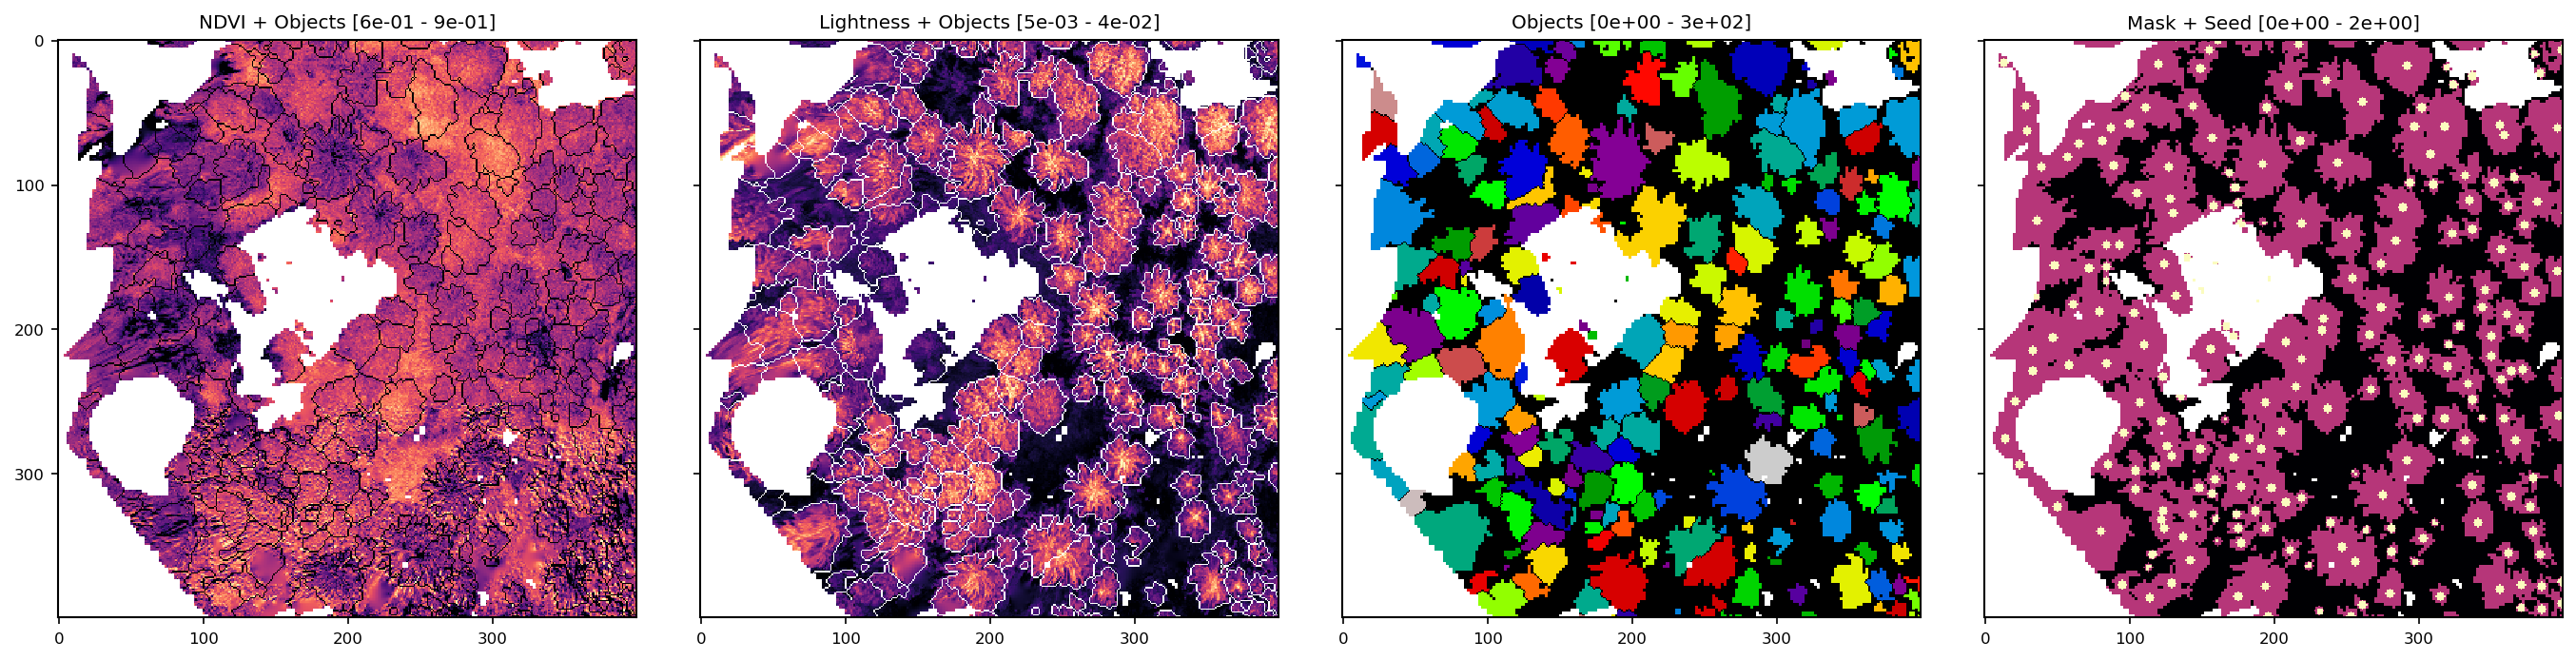

In [32]:
segment_l = cs['l'].copy()
segment_l[bounds == 1] = np.nan

segment_ndvi = cs['ndvi'].copy()
segment_ndvi[bounds == 1] = 0

channels = [
    segment_ndvi, segment_l, labels, mask_seed,
]
use_random_cmap = [
    False, False, True, False, 
    ]
channels_names = [
    'NDVI + Objects','Lightness + Objects', 'Objects', 'Mask + Seed',
]
contrasts = [
    (0.6, 0.9), (5e-3, 3.9e-2), None, None,
]

# ROI
width = 200
x_center = 300
y_center = 1700
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    # n_cols_rows=(3,2),
)

# plt.savefig(r'C:\Users\flori\Desktop\plots\220331_tnr12702_gauss20m.pdf', transparent=True)

### Object properties

In [27]:
import skimage.measure as measure
props = measure.regionprops(labels, cs['l'])
keys = [key for key in props[0]]

props_table = measure.regionprops_table(
    labels,
    cs['ndvi'],
    properties=keys,
    )

props_df = pd.DataFrame(props_table)

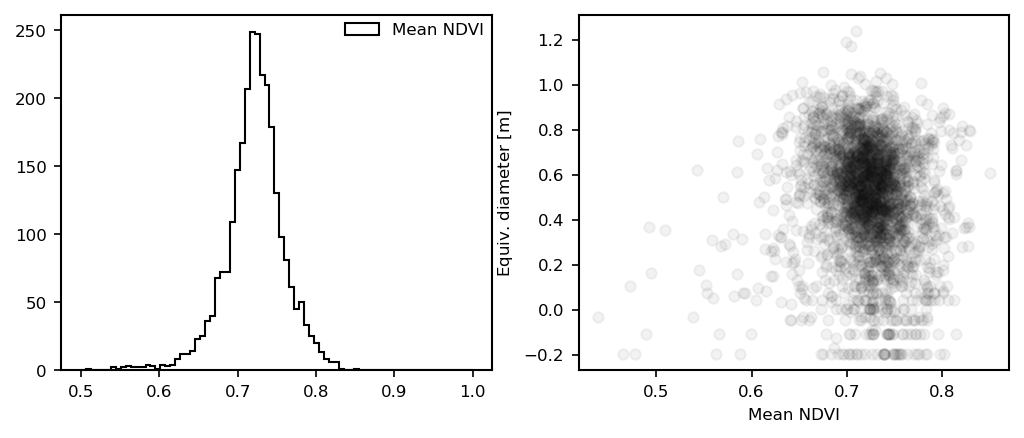

In [28]:
bins = np.linspace(0.5,1, 80)

f, axs = plt.subplots(ncols=2, figsize=[8,3])

ax = axs[0]
_ = ax.hist(
    props_df['intensity_mean'],
    bins=bins,
    histtype='step',
    label='Mean NDVI'
    )
ax.legend()

ax = axs[1]
_ = ax.scatter(
    props_df['intensity_mean'],
    np.log10(props_df['equivalent_diameter_area'] * resolution),
    alpha=0.05,
    )
_ = ax.set_xlabel('Mean NDVI')
_ = ax.set_ylabel(r'Equiv. diameter [$m$]')

In [ ]:
# i = np.random.randint(0,len(props))
# # i = 2593
# print(i)
# prop = props[i]

# mask = prop['image_filled']
# slice = prop['slice']

# l = prop['image_intensity']
# ndvi = cs['ndvi'][slice] * mask

# channels = [mask, l, ndvi]
# contrasts = [(0,1), (1e-3, 3.5e-2), (0.5,1)]
# channel_names = ['Mask', 'L' , 'NDVI']


# f, axs = visual.show_channels(
#     channels,
#     contrasts=contrasts,
#     channel_names=channel_names,
#     zoom=0.8,
# )

# y,x = prop['centroid_local']
# yw,xw = prop['centroid_weighted_local']
# _ = axs[1].scatter(x, y, s=20, marker='o', fc='w', ec='k')
# _ = axs[1].scatter(xw, yw, s=40, marker='s', fc='none', ec='k')
